In [2]:
!pip install scikeras
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
file_path = '/content/final_df.csv'
data = pd.read_csv(file_path)

In [4]:
X = data.drop('churn', axis=1)  # Features
y = data['churn']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(57819, 20) (14455, 20) (57819,) (14455,)


In [19]:
def create_dl_model(dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Гіперпараметри для крос-валідації
dl_param_grid = {'optimizer': ['adam', 'rmsprop'], 'dropout_rate': [0.1, 0.3, 0.7], 'epochs': [10, 25, 50], 'batch_size': [10, 30]}

# Обгортка моделі KerasClassifier з використанням параметрів
def create_keras_model(dropout_rate=0.5):
    return KerasClassifier(build_fn=create_dl_model, dropout_rate=dropout_rate, verbose=0)


Крос-валідація та навчання deep learning моделі

In [21]:
grid_search_dl = GridSearchCV(estimator=create_keras_model(), param_grid=dl_param_grid, cv=3)
grid_search_dl.fit(X_train, y_train, validation_data=(X_test, y_test))
best_dl_model = grid_search_dl.best_estimator_

print(f"Deep Learning Model best params: {grid_search_dl.best_params_}")

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using 

Deep Learning Model best params: {'batch_size': 30, 'dropout_rate': 0.7, 'epochs': 10, 'optimizer': 'adam'}


#Зробимо модель з найкращими підібраними параметрами:

Розбиття на тестову та тренувальну вибірку

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабування даних
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Сама структура моделі

In [41]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Зробимо завчасний стоп, якщо модель буде бачити, що точність зменшується

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [42]:
history = model.fit(X_train, y_train,
                             epochs=10,
                             batch_size=64,
                             validation_data=(X_test, y_test),
                             callbacks=[early_stopping],
                             verbose=0)

In [50]:
# Прогнозування на тестовому наборі
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Оцінка метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred_probs)

print(f"Точність моделі (accuracy): {accuracy}")
print(f"Відклик (recall): {recall}")
print(f"Точність (precision): {precision}")
print(f"F1-скоров: {f1}")
print(f"Середньоквадратична помилка (mean squared error): {mse}")


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Точність моделі (accuracy): 0.97357315807679
Відклик (recall): 0.9710470485461126
Точність (precision): 0.9810868742907578
F1-скоров: 0.9760411440040141
Середньоквадратична помилка (mean squared error): 0.018877670632175263


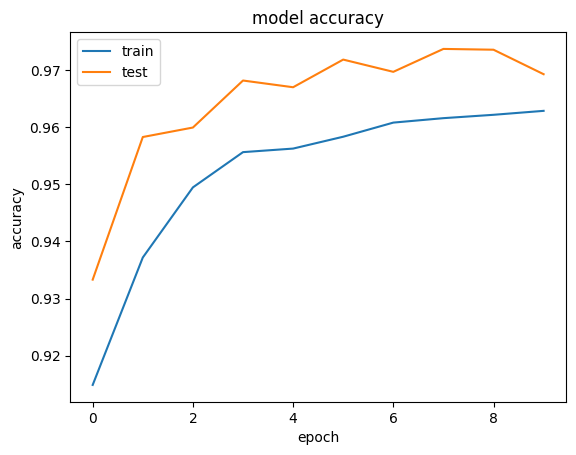

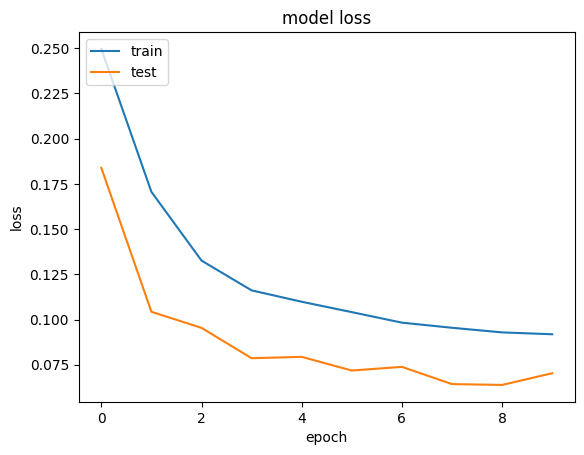

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
        # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Як можна побачити модель не є перенавченою або навпаки недонавченою, вона відповідає усім вимогам щодо навчання моделі.

Завантажимо модель:

In [54]:
model.save('neural_network_model.h5')